# 1. Settings

## 1.1 User variables

In [1]:
MAX_DAY = 4
NB_RUNS = 30

TARGETS = ["Alnus"]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,M15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,0,1,1,2,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,0,1,2,2,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,1,2,1,1,0,0,2,1,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,1,2,2,0,0,0,0,2,...,1,0,1,0,0,0,2,0,0,0
58,0,0,1,1,1,1,0,0,0,2,...,1,0,1,0,1,0,1,0,0,1
59,0,0,2,1,1,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
60,0,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


0 34
2 10
1 18


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 286 - total: 286 - duplicate: 0
Run 2/30 - new rules found: 198 - total: 484 - duplicate: 71
Run 3/30 - new rules found: 96 - total: 580 - duplicate: 171
Run 4/30 - new rules found: 113 - total: 693 - duplicate: 176
Run 5/30 - new rules found: 88 - total: 781 - duplicate: 205
Run 6/30 - new rules found: 42 - total: 823 - duplicate: 219
Run 7/30 - new rules found: 103 - total: 926 - duplicate: 193
Run 8/30 - new rules found: 90 - total: 1016 - duplicate: 181
Run 9/30 - new rules found: 70 - total: 1086 - duplicate: 221
Run 10/30 - new rules found: 56 - total: 1142 - duplicate: 221
Run 11/30 - new rules found: 38 - total: 1180 - duplicate: 227
Run 12/30 - new rules found: 53 - total: 1233 - duplicate: 229
Run 13/30 - new rules found: 65 - total: 1298 - duplicate: 212
Run 14/30 - new rules found: 71 - total: 1369 - duplicate: 201
Run 15/30 - new rules found: 58 - total: 1427 - duplicate: 245
Run 16/30 - new rules found: 59 - total: 1486 - duplicate: 223
Run 17/

,head_variable,head_value,body,rule_size,raw_rule
0,Alnus,0,"Chenopodiaceae(2), Larix(1)",2,"Alnus(0) :- Chenopodiaceae(2), Larix(1)."
1,Alnus,0,"Acer(2), Aquatics(1)",2,"Alnus(0) :- Acer(2), Aquatics(1)."
2,Alnus,0,"Asteraceae(2), Cyperaceae(0)",2,"Alnus(0) :- Asteraceae(2), Cyperaceae(0)."
3,Alnus,0,"Acer(2), Chenopodiaceae(2)",2,"Alnus(0) :- Acer(2), Chenopodiaceae(2)."
4,Alnus,0,"Chenopodiaceae(2), Typha(0)",2,"Alnus(0) :- Chenopodiaceae(2), Typha(0)."
...,...,...,...,...,...
2207,Alnus,2,"Agoseris(0), Aquatics(0), Asteraceae(1), Phyto...",5,"Alnus(2) :- Agoseris(0), Aquatics(0), Asterace..."
2209,Alnus,2,"Agoseris(0), Aquatics(0), Asteraceae(1), Spore...",5,"Alnus(2) :- Agoseris(0), Aquatics(0), Asterace..."
2210,Alnus,2,"Aquatics(0), Asteraceae(1), Cyperaceae(0), Pop...",5,"Alnus(2) :- Aquatics(0), Asteraceae(1), Cypera..."
2211,Alnus,2,"Agoseris(0), Aquatics(0), Asteraceae(1), Cyper...",5,"Alnus(2) :- Agoseris(0), Aquatics(0), Asterace..."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["true_positives"] = true_pos
    df_output["false_positives"] = false_pos
    df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["accuracy","true_positives"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)

 2213/2016


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy
939,Alnus,0,"Corylus(0), Cyperaceae(1), M15(0), Rosaceae(0)...",5,9,0,1.0
1192,Alnus,0,"Fraxinus(0), Typha(1), Ulmus(1)",3,9,0,1.0
1191,Alnus,0,"Larix(1), Populus(0)",2,8,0,1.0
1651,Alnus,0,"Agoseris(0), Juniperus(0), Populus(0)",3,8,0,1.0
1891,Alnus,0,"Agoseris(0), Carpinus(0), Picea(1), Populus(0)",4,8,0,1.0
...,...,...,...,...,...,...,...
2199,Alnus,2,"Agoseris(0), Aquatics(0), Asteraceae(1), Betul...",5,1,0,1.0
2201,Alnus,2,"Asteraceae(1), Cyperaceae(0), Juniperus(0), Po...",5,1,0,1.0
2203,Alnus,2,"Abies(1), Agoseris(0), Asteraceae(1), Spore_tr...",5,1,0,1.0
2205,Alnus,2,"Agoseris(0), Asteraceae(1), Cyperaceae(0), Jun...",6,1,0,1.0


In [9]:
TOP_K_RULES = 5
MIN_SUPPORT = 1

VEN_TOP_K_RULES = 200

TARGETS = ["O15"]

import pandas as pd
import numpy
from upsetplot import UpSet
import matplotlib.pyplot as plt

LEVELS = df_output["head_value"].nunique()
LEVELS

3

In [10]:
def decode(body,include_value=True):
    conditions = []
    body = body.split(", ")

    for token in body:
        condition = token.split("(")[0].strip()
        val = token.split("(")[1].split(")")[0].strip()
        #if condition in metabolite_mapping:
        #    condition = metabolite_mapping[condition]
        if include_value:
            condition += "("+val+")"
        conditions += [condition]
    return conditions

0


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_2675/751918124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
939,Alnus,0,"Corylus(0), Cyperaceae(1), M15(0), Rosaceae(0)...",5,9,0,1.0,"[Corylus(0), Cyperaceae(1), M15(0), Rosaceae(0...",9.0
1192,Alnus,0,"Fraxinus(0), Typha(1), Ulmus(1)",3,9,0,1.0,"[Fraxinus(0), Typha(1), Ulmus(1)]",9.0
1191,Alnus,0,"Larix(1), Populus(0)",2,8,0,1.0,"[Larix(1), Populus(0)]",8.0
1891,Alnus,0,"Agoseris(0), Carpinus(0), Picea(1), Populus(0)",4,8,0,1.0,"[Agoseris(0), Carpinus(0), Picea(1), Populus(0)]",8.0
1651,Alnus,0,"Agoseris(0), Juniperus(0), Populus(0)",3,8,0,1.0,"[Agoseris(0), Juniperus(0), Populus(0)]",8.0


['Agoseris(0)', 'Carpinus(0)', 'Corylus(0)', 'Cyperaceae(1)', 'Fraxinus(0)', 'Juniperus(0)', 'Larix(1)', 'M15(0)', 'Picea(1)', 'Populus(0)', 'Rosaceae(0)', 'Salix(1)', 'Typha(1)', 'Ulmus(1)']
14


true_pos  \
Agoseris(0) Carpinus(0) Corylus(0) Cyperaceae(1) Fraxinus(0) Juniperus(0) Larix(1) M15(0) Picea(1) Populus(0) Rosaceae(0) Salix(1) Typha(1) Ulmus(1)             
False       False       False      False         False       False        True     False  False    True       False       False    False    False            8   
                                                 True        False        False    False  False    False      False       False    True     True             9   
                        True       True          False       False        False    True   False    False      True        True     False    False            9   
True        False       False      False         False       True         False    False  False    True       False       False    False    False            8   
            True        False      False         False       False        False    False  True     True       False       False    False    False            8   

                                                                                                                                                      false_pos  \
Agoseris(0) Carpinus(0) Corylus(0) Cyperaceae(1) Fraxinus(0) Juniperus(0) Larix(1) M15(0) Picea(1) Populus(0) Rosaceae(0) Salix(1) Typha(1) Ulmus(1)              
False       False       False      False         False       False        True     False  False    True       False       False    False    False             0   
                                                 True        False        False    False  False    False      False       False    True     True              0   
                        True       True          False       False        False    True   False    False      True        True     False    False             0   
True        False       False      False         False       True         False    False  False    True       False       False    False    False             0   
            True        False      False         False       False        False    False  True     True       False       False    False    False             0   

                                                                                                                                                      accuracy  \
Agoseris(0) Carpinus(0) Corylus(0) Cyperaceae(1) Fraxinus(0) Juniperus(0) Larix(1) M15(0) Picea(1) Populus(0) Rosaceae(0) Salix(1) Typha(1) Ulmus(1)             
False       False       False      False         False       False        True     False  False    True       False       False    False    False        100.0   
                                                 True        False        False    False  False    False      False       False    True     True         100.0   
                        True       True          False       False        False    True   False    False      True        True     False    False        100.0   
True        False       False      False         False       True         False    False  False    True       False       False    False    False        100.0   
            True        False      False         False       False        False    False  True     True       False       False    False    False        100.0   

                                                                                                                                                      confidence  
Agoseris(0) Carpinus(0) Corylus(0) Cyperaceae(1) Fraxinus(0) Juniperus(0) Larix(1) M15(0) Picea(1) Populus(0) Rosaceae(0) Salix(1) Typha(1) Ulmus(1)              
False       False       False      False         False       False        True     False  False    True       False       False    False    False            8.0  
                                                 True        False        False    False  False    False      False       False    True     True             9.0  
                        True       True          False       False        False    Tru

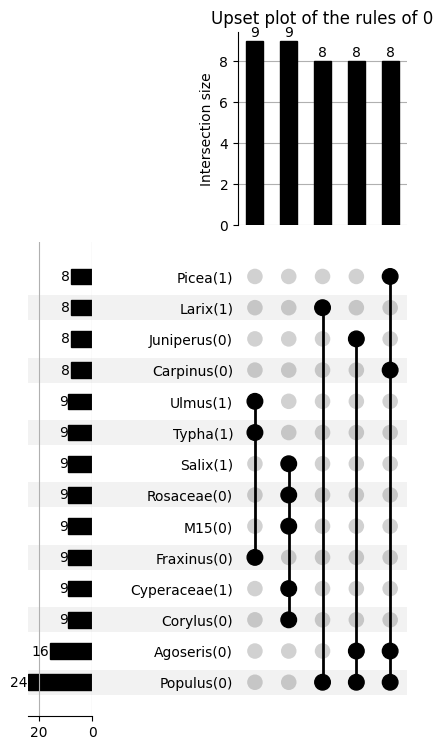

1


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_2675/751918124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
419,Alnus,1,"Carpinus(0), Lycopod(1)",2,5,0,1.0,"[Carpinus(0), Lycopod(1)]",5.0
648,Alnus,1,"Aquatics(1), M15(0), Poaceae(1), Sarcobatus(0)",4,4,0,1.0,"[Aquatics(1), M15(0), Poaceae(1), Sarcobatus(0)]",4.0
651,Alnus,1,"Aquatics(1), Betula(1), Ulmus(0)",3,4,0,1.0,"[Aquatics(1), Betula(1), Ulmus(0)]",4.0
1868,Alnus,1,"Acer(1), Salix(0)",2,4,0,1.0,"[Acer(1), Salix(0)]",4.0
417,Alnus,1,"Lycopod(1), Populus(1)",2,4,0,1.0,"[Lycopod(1), Populus(1)]",4.0


['Acer(1)', 'Aquatics(1)', 'Betula(1)', 'Carpinus(0)', 'Lycopod(1)', 'M15(0)', 'Poaceae(1)', 'Populus(1)', 'Salix(0)', 'Sarcobatus(0)', 'Ulmus(0)']
11


true_pos  \
Acer(1) Aquatics(1) Betula(1) Carpinus(0) Lycopod(1) M15(0) Poaceae(1) Populus(1) Salix(0) Sarcobatus(0) Ulmus(0)             
False   False       False     False       True       False  False      True       False    False         False            4   
                              True        True       False  False      False      False    False         False            5   
        True        False     False       False      True   True       False      False    True          False            4   
                    True      False       False      False  False      False      False    False         True             4   
True    False       False     False       False      False  False      False      True     False         False            4   

                                                                                                                   false_pos  \
Acer(1) Aquatics(1) Betula(1) Carpinus(0) Lycopod(1) M15(0) Poaceae(1) Populus(1) Salix(0) Sarcobatus(0) Ulmus(0)              
False   False       False     False       True       False  False      True       False    False         False             0   
                              True        True       False  False      False      False    False         False             0   
        True        False     False       False      True   True       False      False    True          False             0   
                    True      False       False      False  False      False      False    False         True              0   
True    False       False     False       False      False  False      False      True     False         False             0   

                                                                                                                   accuracy  \
Acer(1) Aquatics(1) Betula(1) Carpinus(0) Lycopod(1) M15(0) Poaceae(1) Populus(1) Salix(0) Sarcobatus(0) Ulmus(0)             
False   False       False     False       True       False  False      True       False    False         False        100.0   
                              True        True       False  False      False      False    False         False        100.0   
        True        False     False       False      True   True       False      False    True          False        100.0   
                    True      False       False      False  False      False      False    False         True         100.0   
True    False       False     False       False      False  False      False      True     False         False        100.0   

                                                                                                                   confidence  
Acer(1) Aquatics(1) Betula(1) Carpinus(0) Lycopod(1) M15(0) Poaceae(1) Populus(1) Salix(0) Sarcobatus(0) Ulmus(0)              
False   False       False     False       True       False  False      True       False    False         False            4.0  
                              True        True       False  False      False      False    False         False            5.0  
        True        False     False       False      True   True       False      False    True          False            4.0  
                    True      False       False      False  False      False      False    False         True             4.0  
True    False       False     False       False      False  False      False      True     False         False            4.0

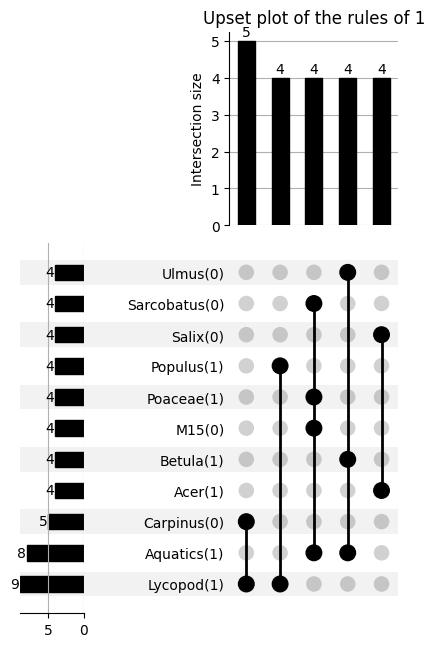

2


/var/folders/5z/5b9s4d6j7bxdtr86gh33vmc80000gn/T/ipykernel_2675/751918124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["confidence"] = df["true_positives"] * df["accuracy"]


,head_variable,head_value,body,rule_size,true_positives,false_positives,accuracy,features,confidence
239,Alnus,2,Rosaceae(2),1,4,0,1.0,[Rosaceae(2)],4.0
1672,Alnus,2,"Corylus(0), Cyperaceae(0), Juniperus(0), Popul...",5,4,0,1.0,"[Corylus(0), Cyperaceae(0), Juniperus(0), Popu...",4.0
1914,Alnus,2,"Ambrosia(0), Corylus(0), Cyperaceae(0), Junipe...",5,4,0,1.0,"[Ambrosia(0), Corylus(0), Cyperaceae(0), Junip...",4.0
1568,Alnus,2,"Aquatics(0), Juniperus(0), Populus(1), Spore_t...",5,4,0,1.0,"[Aquatics(0), Juniperus(0), Populus(1), Spore_...",4.0
1571,Alnus,2,"Acer(0), Aquatics(0), Juniperus(0), Spore_tril...",5,4,0,1.0,"[Acer(0), Aquatics(0), Juniperus(0), Spore_tri...",4.0


['Acer(0)', 'Ambrosia(0)', 'Aquatics(0)', 'Corylus(0)', 'Cyperaceae(0)', 'Juniperus(0)', 'Populus(1)', 'Rosaceae(2)', 'Spore_trilete(0)', 'Thalictrum(0)', 'Ulmus(0)']
11


true_pos  \
Acer(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(0) Juniperus(0) Populus(1) Rosaceae(2) Spore_trilete(0) Thalictrum(0) Ulmus(0)             
False   False       False       False      False         False        False      True        False            False         False            4   
                                True       True          True         True       False       False            True          False            4   
                    True        False      False         True         True       False       True             False         True             4   
        True        False       True       True          True         False      False       False            True          False            4   
True    False       True        False      False         True         False      False       True             False         True             4   

                                                                                                                                      false_pos  \
Acer(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(0) Juniperus(0) Populus(1) Rosaceae(2) Spore_trilete(0) Thalictrum(0) Ulmus(0)              
False   False       False       False      False         False        False      True        False            False         False             0   
                                True       True          True         True       False       False            True          False             0   
                    True        False      False         True         True       False       True             False         True              0   
        True        False       True       True          True         False      False       False            True          False             0   
True    False       True        False      False         True         False      False       True             False         True              0   

                                                                                                                                      accuracy  \
Acer(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(0) Juniperus(0) Populus(1) Rosaceae(2) Spore_trilete(0) Thalictrum(0) Ulmus(0)             
False   False       False       False      False         False        False      True        False            False         False        100.0   
                                True       True          True         True       False       False            True          False        100.0   
                    True        False      False         True         True       False       True             False         True         100.0   
        True        False       True       True          True         False      False       False            True          False        100.0   
True    False       True        False      False         True         False      False       True             False         True         100.0   

                                                                                                                                      confidence  
Acer(0) Ambrosia(0) Aquatics(0) Corylus(0) Cyperaceae(0) Juniperus(0) Populus(1) Rosaceae(2) Spore_trilete(0) Thalictrum(0) Ulmus(0)              
False   False       False       False      False         False        False      True        False            False         False            4.0  
                                True       True          True         True       False       False            True          False            4.0  
                    True        False      False         True         True       False       True             False         True             4.0  
        True        False       True       True          True         False      False       False            True          False            4.0  
True    False       True        False      False         True         False      False       True             False         True             4.0

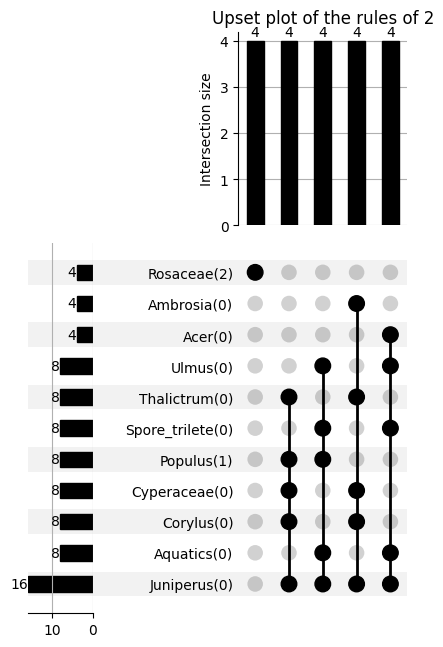

In [11]:
df_raw = df_output.copy()

df_raw["features"] = df_raw["body"].apply(lambda x: decode(x))

for head in df_raw["head_value"].unique():
    print(head)
    df = df_raw[(df_raw["head_value"] == head) & (df_raw["true_positives"] >= MIN_SUPPORT)]
    df["confidence"] = df["true_positives"] * df["accuracy"]
    df = df.sort_values("confidence", ascending=False).head(TOP_K_RULES)
    #df = df.sort_values("true_positives", ascending=False).head(TOP_K_RULES)

    display(df)

    features = set()
    for idx, row in df.iterrows():
        for i in row["features"]:
            features.add(i)

    features = list(features)
    features.sort()

    print(features)
    print(len(features))

    df_features = pd.DataFrame(columns=features)

    for idx, row in df.iterrows():
        data = {key:[False] for key in features}
        for condition in row["features"]:
            data[condition] = [True]
        df_features = pd.concat([df_features, pd.DataFrame(data)], axis=0).astype({key:bool for key in features})

    df_features["true_pos"] = df["true_positives"].values
    df_features["false_pos"] = df["false_positives"].values
    df_features["accuracy"] = df["accuracy"].values * 100
    df_features["confidence"] = df["confidence"].values
    df = df_features.reset_index(drop=True)

    # Clean useless column
    for col in features:
        if (not True in list(df[col].unique())):
            df = df.drop([col], axis=1)

    #display(df)

    conditions = [c for c in list(df.columns) if c not in ["true_pos","false_pos","accuracy","confidence"]]
    df = df.groupby(conditions).sum(numeric_only=True)
    display(df)

    upset = UpSet(df, show_counts=True, sort_by="cardinality", sum_over='confidence', subset_size="sum")
    #upset.add_catplot(kind="bar",value="false_pos")
    #upset.add_catplot(kind="bar",value="true_pos", color="blue")
    #upset.add_catplot(kind="bar",value="false_pos", color="red")
    #upset.add_catplot(kind="bar",value="accuracy", color="gray")
    upset.plot()
    plt.title("Upset plot of the rules of "+str(head), loc="center")
    plt.savefig("tmp/upset_plot_lfit_"+str(head)+"_top_"+str(TOP_K_RULES)+"_lvl_"+str(LEVELS)+".pdf",bbox_inches='tight')
    plt.show()


# Vendiagram

In [12]:
def coverage(head_var, head_val, body,df):
    true_pos = 0
    false_pos = 0

    #print(body)

    conditions = body.split("), ")

    body = []
    for token in conditions:
        var = token.split("(")[0].strip()
        val = token.split("(")[1].split("(")[0].replace(")","").replace(".","").strip()
        if val.isdigit():
            val = int(val)
        body+= [(var,val)]

    #print((head_var, head_val), body)
        
    true_pos = []
    false_pos = []
    unknown_true_pos = []
    unknown_false_pos = []

    for idx, row in df.iterrows():
        matches = "FULL"
        for var,val in body:
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[head_var]) == str(head_val):
                true_pos += [idx]
            else:
                false_pos += [idx]
        elif matches == "PARTIAL":
            if str(row[head_var]) == str(head_val):
                unknown_true_pos += [idx]
            else:
                unknown_false_pos += [idx]

    
    #print(len(true_pos), len(false_pos), len(unknown_true_pos), len(unknown_false_pos))
    return true_pos, false_pos, unknown_true_pos, unknown_false_pos
    
df = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')
df = df.fillna("?")
display(df)

tp, fp, utp, ufp = coverage("M15", "0", "Abies(1), Pinus(1)", df)
print(len(tp), len(fp), len(utp), len(ufp))

,M15,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore_monolete_,Spore_trilete,Aquatics
0,0,1,1,2,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,2,2,0
2,0,1,2,2,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,1,1,2,1,1,0,0,2,1,...,1,0,0,1,0,0,0,0,0,0
4,1,2,0,2,1,1,0,1,0,0,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,1,2,2,0,0,0,0,2,...,1,0,1,0,0,0,2,0,0,0
58,0,0,1,1,1,1,0,0,0,2,...,1,0,1,0,1,0,1,0,0,1
59,0,0,2,1,1,1,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
60,0,0,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


9 5 0 0


In [13]:
from matplotlib_venn import venn3

# find subset of rules of max size that cover all sample
df_data = pd.read_csv(INPUT_DATA_DISCRETE)
cols = [c for c in df_data.columns if c not in list(df_data.select_dtypes(exclude=["number"]).columns)]
df_data[cols] = df_data[cols].astype('Int64')
df_data[cols] = df_data[cols].astype('string')
df_data = df_data.fillna("?")
#df_data = df_data.dropna() # DBG remove if nan lfit mode
#display(df_data)
df_rules = df_output.copy()

for head_value in list(df_rules["head_value"].unique()):
    # Extract top rules
    df_rules = df_output.copy()
    df_rules = df_rules[(df_rules["head_value"] == head_value) & (df_rules["true_positives"] >= MIN_SUPPORT)]

    # DBG
    #df_rules = df_rules.sort_values("train_true_positives", ascending=False).reset_index(drop=True)
    #df_rules = df_rules.truncate(before=19417).reset_index(drop=True)
    df_rules = df_rules.sort_values("true_positives", ascending=False).reset_index(drop=True).head(VEN_TOP_K_RULES).reset_index(drop=True)
    #display(df_rules)

    # Compute covering
    rule_covering = {}
    for idx, row in df_rules.iterrows():
        tp, fp, utp, ufp = coverage(row["head_variable"], row["head_value"], row["body"], df_data)
        rule_covering[idx] = {"tp":set(tp), "fp":set(fp), "utp":set(utp), "ufp":set(ufp)}
        print("\r",idx+1,"/",len(df_rules),end="")
    print()

    # Greedy search for minimal set covering
    remaining = set(df_data[df_data[TARGETS[0]] == head_value].index.values.tolist())
    total_to_cover = len(remaining)
    selection = []
    while (len(remaining) > 0) and (len(rule_covering) > 0) and (len(selection) < 3):
        print("Remaining:",len(remaining))

        covering = []
        for rule_id in rule_covering:
            new_tp = len(remaining.intersection(rule_covering[rule_id]["tp"])) + len(remaining.intersection(rule_covering[rule_id]["utp"]))
            if (new_tp > 0):
                covering += [(rule_id, new_tp, len(rule_covering[rule_id]["fp"]) + len(rule_covering[rule_id]["ufp"]))]
        covering.sort(key = lambda x: (x[1],-x[2]),reverse=True) # Maximize TP, minimize FP
        print(covering)

        if covering[0][1] == 0:
            print("No rule cover the remaining observations")
            break

        top_rule_id = covering[0][0]
        selection += [top_rule_id]
        remaining = remaining - rule_covering[top_rule_id]["tp"] - rule_covering[top_rule_id]["utp"]
        #del rule_covering[top_rule_id]


    # True positives covering
    set1 = set(rule_covering[selection[0]]["tp"]).union(rule_covering[selection[0]]["utp"])
    set2 = set(rule_covering[selection[1]]["tp"]).union(rule_covering[selection[1]]["utp"])
    set3 = set(rule_covering[selection[2]]["tp"]).union(rule_covering[selection[2]]["utp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    nb_covered = total_to_cover-len(remaining)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    plt.title(str(head_value)+" true positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_TP.pdf",bbox_inches='tight')
    plt.show()

    #if dataset_name == "PREVHAP":
    # False positives covering
    set1 = set(rule_covering[selection[0]]["ufp"]).union(rule_covering[selection[0]]["fp"])
    set2 = set(rule_covering[selection[1]]["ufp"]).union(rule_covering[selection[1]]["fp"])
    set3 = set(rule_covering[selection[2]]["ufp"]).union(rule_covering[selection[2]]["fp"])

    venn3([set1, set2, set3], ("Rule "+str(selection[0]), "Rule "+str(selection[1]), "Rule "+str(selection[2])))

    total_to_cover = len(set(df_data[df_data[TARGETS[0]] != head_value].index.values.tolist()))
    nb_covered = set1
    nb_covered.update(set2)
    nb_covered.update(set3)
    nb_covered = len(nb_covered)
    pct_covered = int(nb_covered / total_to_cover * 100)
    r0 = decode(df_rules["body"].iloc[[selection[0]]].values[0])
    r1 = decode(df_rules["body"].iloc[[selection[1]]].values[0])
    r2 = decode(df_rules["body"].iloc[[selection[2]]].values[0])
    print("Rule "+str(selection[0])+": "+str(r0))
    print("Rule "+str(selection[1])+": "+str(r1))
    print("Rule "+str(selection[2])+": "+str(r2))
    plt.title(str(head_value)+" false positives covering "+str(nb_covered)+"/"+str(total_to_cover)+" (~"+str(pct_covered)+"%)")
    #plt.text(1, 0, "Rule "+str(selection[0])+": "+str(r0), fontsize = 12) 
    #plt.text(1, -0.1, "Rule "+str(selection[1])+": "+str(r1), fontsize = 12)
    #plt.text(1, -0.2, "Rule "+str(selection[2])+": "+str(r2), fontsize = 12)
    plt.savefig("tmp/ven_diag_"+str(head_value)+"_FP.pdf",bbox_inches='tight')
    plt.show()



 200 / 200


KeyError: 'O15'

# TODO